In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
df = pd.read_csv('weather_data/weather_data.csv', parse_dates=['Date'])
df.head()


,Date,Month,Week,Year,City,Code,Location,State,Avg_Temp,Max_Temp,Min_Temp,Wind_Direction,Wind_Speed,Precipitation
0,2016-03-01,1,3,2016,Birmingham,BHM,"Birmingham, AL",Alabama,39,46,32,33,4.33,0.00
1,2016-03-01,1,3,2016,Huntsville,HSV,"Huntsville, AL",Alabama,39,47,31,32,3.86,0.00
2,2016-03-01,1,3,2016,Mobile,MOB,"Mobile, AL",Alabama,46,51,41,35,9.73,0.16
3,2016-03-01,1,3,2016,Montgomery,MGM,"Montgomery, AL",Alabama,45,52,38,32,6.86,0.00
4,2016-03-01,1,3,2016,Anchorage,ANC,"Anchorage, AK",Alaska,34,38,29,19,7.80,0.01


In [11]:
# we have to take one city at a time
df = df.query('City == "Meridian"')
df.head()

,Date,Month,Week,Year,City,Code,Location,State,Avg_Temp,Max_Temp,Min_Temp,Wind_Direction,Wind_Speed,Precipitation
156,2016-03-01,1,3,2016,Meridian,MEI,"Meridian, MS",Mississippi,43,49,36,34,5.56,0.01
471,2016-10-01,1,10,2016,Meridian,MEI,"Meridian, MS",Mississippi,45,53,33,13,5.37,0.10
786,2016-01-17,1,17,2016,Meridian,MEI,"Meridian, MS",Mississippi,44,58,29,22,3.55,0.10
1101,2016-01-24,1,24,2016,Meridian,MEI,"Meridian, MS",Mississippi,42,52,31,17,6.17,1.50
1416,2016-01-31,1,31,2016,Meridian,MEI,"Meridian, MS",Mississippi,50,65,36,20,6.77,1.53


In [12]:
df.corr()

/var/folders/7p/nhr_8mz933v_4r1mwyd3_jg40000gp/T/ipykernel_16756/1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,Month,Week,Year,Avg_Temp,Max_Temp,Min_Temp,Wind_Direction,Wind_Speed,Precipitation
Month,1.000000,0.014609,-0.212114,0.350583,0.400831,0.293398,-0.157949,-0.475943,-0.283132
Week,0.014609,1.000000,-0.227895,0.041482,0.078859,0.012728,-0.229007,0.000685,0.130644
Year,-0.212114,-0.227895,1.000000,-0.074533,-0.076086,-0.066155,0.141300,0.073899,0.055394
Avg_Temp,0.350583,0.041482,-0.074533,1.000000,0.981612,0.981566,-0.105434,-0.515221,-0.037885
Max_Temp,0.400831,0.078859,-0.076086,0.981612,1.000000,0.928735,-0.080544,-0.568715,-0.121945
Min_Temp,0.293398,0.012728,-0.066155,0.981566,0.928735,1.000000,-0.123799,-0.436163,0.056370
Wind_Direction,-0.157949,-0.229007,0.141300,-0.105434,-0.080544,-0.123799,1.000000,0.022570,-0.213709
Wind_Speed,-0.475943,0.000685,0.073899,-0.515221,-0.568715,-0.436163,0.022570,1.000000,0.500325
Precipitation,-0.283132,0.130644,0.055394,-0.037885,-0.121945,0.056370,-0.213709,0.500325,1.000000


In [13]:
df.set_index('Date', inplace=True)


In [14]:
df.drop(["Month", "Week", "Year", "City", "Code", "Location", "State"], axis=1, inplace=True)
df.head()

,Avg_Temp,Max_Temp,Min_Temp,Wind_Direction,Wind_Speed,Precipitation
Date,,,,,,
2016-03-01,43,49,36,34,5.56,0.01
2016-10-01,45,53,33,13,5.37,0.10
2016-01-17,44,58,29,22,3.55,0.10
2016-01-24,42,52,31,17,6.17,1.50
2016-01-31,50,65,36,20,6.77,1.53


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53 entries, 2016-03-01 to 2017-01-01
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Avg_Temp        53 non-null     int64  
 1   Max_Temp        53 non-null     int64  
 2   Min_Temp        53 non-null     int64  
 3   Wind_Direction  53 non-null     int64  
 4   Wind_Speed      53 non-null     float64
 5   Precipitation   53 non-null     float64
dtypes: float64(2), int64(4)
memory usage: 2.9 KB


In [16]:
# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

In [17]:
train_df.head()

,Avg_Temp,Max_Temp,Min_Temp,Wind_Direction,Wind_Speed,Precipitation
Date,,,,,,
2016-03-01,43,49,36,34,5.56,0.01
2016-10-01,45,53,33,13,5.37,0.10
2016-01-17,44,58,29,22,3.55,0.10
2016-01-24,42,52,31,17,6.17,1.50
2016-01-31,50,65,36,20,6.77,1.53


In [18]:
test_df.head()

,Avg_Temp,Max_Temp,Min_Temp,Wind_Direction,Wind_Speed,Precipitation
Date,,,,,,
2016-10-23,69,84,54,19,3.90,0.00
2016-10-30,69,87,50,18,1.40,0.00
2016-06-11,67,83,49,17,2.90,0.00
2016-11-13,60,73,45,16,3.20,0.20
2016-11-20,57,74,39,28,3.61,0.01


In [19]:
# Preprocess the data
scaler = MinMaxScaler()

In [20]:
# Scale the numeric columns in your DataFrame
numeric_columns = ['Precipitation']


In [21]:
scaled_train_data = scaler.fit_transform(train_df[numeric_columns])
scaled_test_data = scaler.transform(test_df[numeric_columns])

In [22]:
# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        targets.append(data[i+seq_length, -1])  # Target is the last column (Precipitation)
    return np.array(sequences), np.array(targets)

In [23]:
# Define sequence length (number of time steps to look back)
seq_length = 5  # You can adjust this

In [24]:
# Create sequences and targets for training and testing data
train_sequences, train_target = create_sequences(scaled_train_data, seq_length)
test_sequences, test_target = create_sequences(scaled_test_data, seq_length)

In [25]:
train_sequences.shape, train_target.shape

((37, 5, 1), (37,))

In [26]:
test_sequences.shape, test_target.shape

((6, 5, 1), (6,))

In [27]:
# Build the model
model = Sequential()
model.add(LSTM(50, input_shape=(seq_length, len(numeric_columns))))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

Metal device set to: Apple M1 Pro


In [28]:
# Train the model
history = model.fit(train_sequences, train_target, epochs=100, batch_size=32, validation_data=(test_sequences, test_target), verbose=2)


Epoch 1/100
2/2 - 1s - loss: 0.0609 - val_loss: 0.0161 - 1s/epoch - 599ms/step
Epoch 2/100
2/2 - 0s - loss: 0.0559 - val_loss: 0.0134 - 40ms/epoch - 20ms/step
Epoch 3/100
2/2 - 0s - loss: 0.0517 - val_loss: 0.0112 - 38ms/epoch - 19ms/step
Epoch 4/100
2/2 - 0s - loss: 0.0482 - val_loss: 0.0095 - 38ms/epoch - 19ms/step
Epoch 5/100
2/2 - 0s - loss: 0.0454 - val_loss: 0.0082 - 38ms/epoch - 19ms/step
Epoch 6/100
2/2 - 0s - loss: 0.0434 - val_loss: 0.0074 - 40ms/epoch - 20ms/step
Epoch 7/100
2/2 - 0s - loss: 0.0420 - val_loss: 0.0069 - 39ms/epoch - 20ms/step
Epoch 8/100
2/2 - 0s - loss: 0.0417 - val_loss: 0.0068 - 38ms/epoch - 19ms/step
Epoch 9/100
2/2 - 0s - loss: 0.0412 - val_loss: 0.0070 - 37ms/epoch - 18ms/step
Epoch 10/100
2/2 - 0s - loss: 0.0412 - val_loss: 0.0072 - 38ms/epoch - 19ms/step
Epoch 11/100
2/2 - 0s - loss: 0.0419 - val_loss: 0.0077 - 37ms/epoch - 18ms/step
Epoch 12/100
2/2 - 0s - loss: 0.0425 - val_loss: 0.0080 - 37ms/epoch - 18ms/step
Epoch 13/100
2/2 - 0s - loss: 0.0429 -

In [29]:
# Make predictions on the test set
test_predictions = model.predict(test_sequences)

1/1 [==============================] - 0s 203ms/step


In [30]:
print(f"{scaled_test_data}")
print(f"{test_predictions}")

[[0.        ]
 [0.        ]
 [0.        ]
 [0.03322259]
 [0.00166113]
 [0.00166113]
 [0.11627907]
 [0.12126246]
 [0.22093023]
 [0.        ]
 [0.18936877]]
[[0.08971955]
 [0.08964491]
 [0.09495163]
 [0.09989575]
 [0.10823821]
 [0.10576545]]


In [31]:
# Inverse transform the predictions and target to the original scale
test_predictions = scaler.inverse_transform(test_predictions)  # Exclude Precipitation column
test_target_original = scaler.inverse_transform(test_target.reshape(-1, 1))


In [32]:
# Calculate RMSE on the original scale
rmse = np.sqrt(mean_squared_error(test_target_original, test_predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 0.5067198667949466


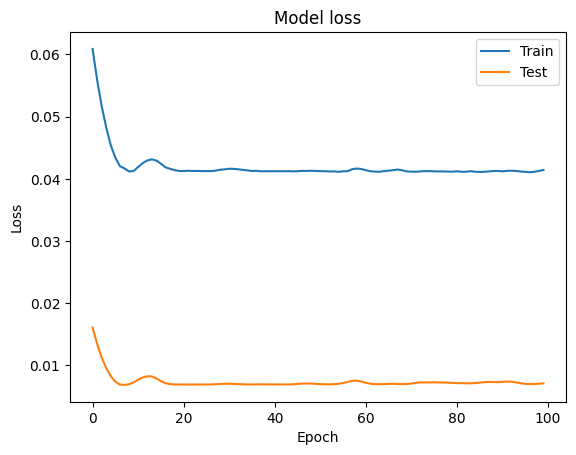

In [33]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()